# Goodreads visualization

An ipython notebook to play around with Goodreads data and make some seaborn visualizations, learn more about scikit-learn, my own playground!

You can use it with your own data - go [here](https://www.goodreads.com/review/import) and press "Export your library" to get your own csv.

The text you're reading is generated from a jupyter notebook by the Makefile. If you want to run it yourself, clone the repository then run

    jupyter notebook your_file.ipynb
    
to get the interactive version. In there, replace the path to my Goodreads exported file by yours in the ipynb file, and then run click on Cell -> Run All.

## Dependencies

* Python (2?)
* Jupyter

### Python packages

* seaborn
* pandas
* wordcloud
* nltk
* networkx
* pymarkovchain
* scikit-learn
* distance
* image (PIL inside python for some weird reason)

To install all:

    pip install seaborn wordcloud nltk networkx pymarkovchain image sklearn distance

## Licenses

License for reviews: CC-BY-SA 4.0
Code: MIT

OK, let's start!

## Setting up the notebook

In [1]:
% pylab inline


# for most plots
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter, OrderedDict

# for stats
import scipy.stats

# for time-related plots
import datetime
import calendar

# for word cloud
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

# for Markov chain
from pymarkovchain import MarkovChain
import pickle
import networkx as nx

# for shelf clustering
import distance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

sns.set_palette("coolwarm")

# for plotting images
from IPython.display import Image

# for gender guessing
import gender_guesser.detector as gender

Populating the interactive namespace from numpy and matplotlib


## Loading the data

In [2]:
df = pd.read_csv('./goodreads_export.csv')
# keep only books that have a rating (unrated books have a rating of 0, we don't need that)
cleaned_df = df[df["My Rating"] != 0]

# Score distribution
With a score scale of 1-5, you'd expect that the average score is ~~2.5~~ 3 (since 0 is not counted) after a few hundred books (in other words, is it a normal distribution?)

('Average: 3.62', 'Median: 4.0')

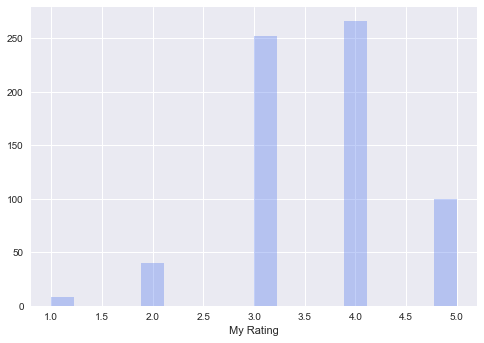

In [3]:
g = sns.distplot(cleaned_df["My Rating"], kde=False)
"Average: %.2f"%cleaned_df["My Rating"].mean(), "Median: %s"%cleaned_df["My Rating"].median()

That doesn't look normally distributed to me - let's ask Shapiro-Wilk (null hypothesis: data is drawn from normal distribution):

In [4]:
W, p_value = scipy.stats.shapiro(cleaned_df["My Rating"])
if p_value < 0.05:
    print("Rejecting null hypothesis - data does not come from a normal distribution (p=%s)"%p_value)
else:
    print("Cannot reject null hypothesis (p=%s)"%p_value)

Rejecting null hypothesis - data does not come from a normal distribution (p=7.07092190733e-23)


In my case, the data is not normally distributed (in other words, the book scores are not evenly distributed around the middle). If you think about it, this makes sense: most readers don't read perfectly randomly, I avoid books I believe I'd dislike, and choose books that I prefer. I rate those books higher than average, therefore, my curve of scores is slanted towards the right.

## plot Pages vs Ratings

Do I give longer books better scores? A minor tendency but nothing special (it's confounded by having just 5 possible numbers in ratings)

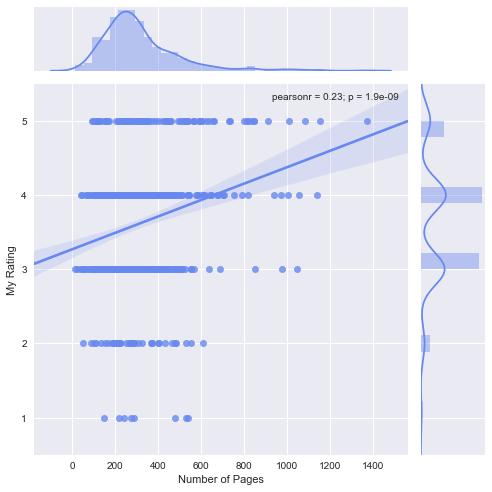

In [5]:
g = sns.jointplot("Number of Pages", "My Rating", data=cleaned_df, kind="reg", size=7, ylim=[0.5,5.5])

I seem to mostly read books at around 200 to 300 pages so it's hard to tell whether I give longer books better ratings. It's also a nice example that in regards to linear regression, a p-value as tiny as this one doesn't mean much, the r-value is still bad.

***

## plot Ratings vs Bookshelves

Let's parse ratings for books and make a violin plot for the 7 categories with the most rated books!

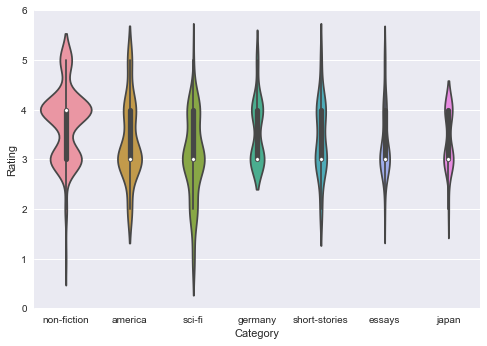

In [6]:
CATEGORIES = 7 # number of most crowded categories to plot

# we have to fiddle a bit - we have to count the ratings by category, 
# since each book can have several comma-delimited categories
# TODO: find a pandas-like way to do this

shelves_ratings = defaultdict(list) # key: shelf-name, value: list of ratings
shelves_counter = Counter() # counts how many books on each shelf
shelves_to_names = defaultdict(list) # key: shelf-name, value: list of book names

for index, row in cleaned_df.iterrows():
    my_rating = row["My Rating"]
    if my_rating == 0:
        continue
    if pd.isnull(row["Bookshelves"]):
        continue

    shelves = row["Bookshelves"].split(",")

    for s in shelves:
        # empty shelf?
        if not s: continue
        s = s.strip() # I had "non-fiction" and " non-fiction"
        shelves_ratings[s].append(my_rating)
        shelves_counter[s] += 10
        shelves_to_names[s].append(row.Title)

names = []
ratings = []
for name, _ in shelves_counter.most_common(CATEGORIES):
    for number in shelves_ratings[name]:
        names.append(name)
        ratings.append(number)

full_table = pd.DataFrame({"Category":names, "Rating":ratings})

# if we don't use scale=count here then each violin has the same area
sns.violinplot(x = "Category", y = "Rating", data=full_table, scale='count')

There is some *bad* SF out there.

At this point I wonder - since we can assign multiple 'shelves' (tags) to each book, do I have some tags that appear more often together than not? Let's use R!

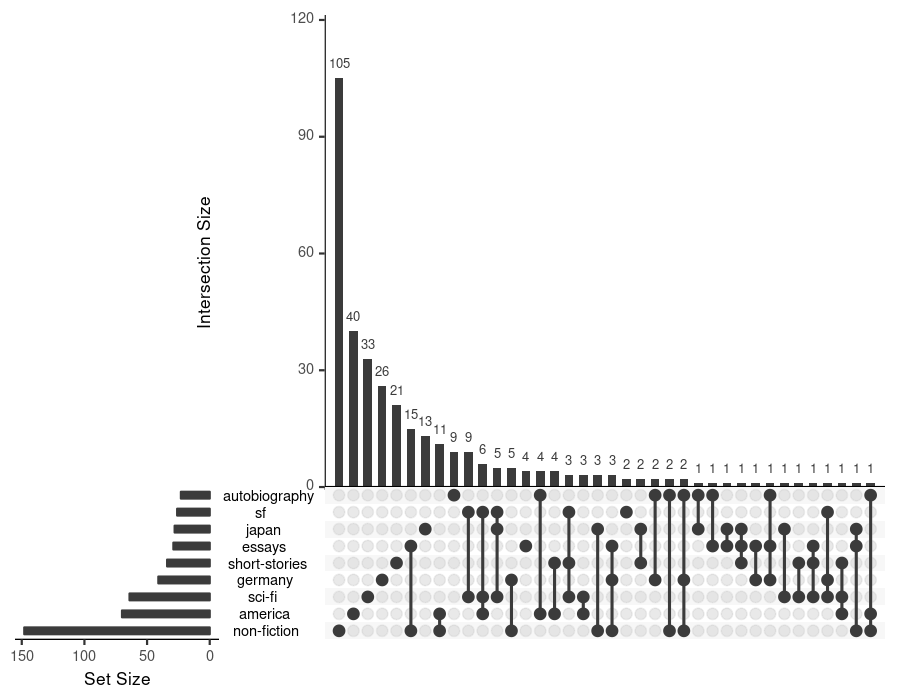

In [7]:
from rpy2 import robjects

all_shelves = shelves_counter.keys()
names_dict = {} # key: shelf name, value: robjects.StrVector of names
for c in all_shelves:
    names_dict[c] = robjects.StrVector(shelves_to_names[c])

names_dict = robjects.ListVector(names_dict)    
%load_ext rpy2.ipython
%R library(UpSetR)
# by default, only 5 sets are considered, so change nsets

%R -i names_dict -r 150 -w 900 -h 700 upset(fromList(names_dict), order.by = "freq", nsets = 9)

Most shelves are 'alone', but 'essays + non-fiction', 'sci-fi + sf' (should clean that up...), 'biography + non-fiction' show the biggest overlap.

I may have messed up the categories, let's cluster them! Typos should cluster together

In [8]:
# get the Levenshtein distance between all shelf titles, normalise the distance by string length
X = np.array([[float(distance.levenshtein(shelf_1,shelf_2))/max(len(shelf_1), len(shelf_2)) \
               for shelf_1 in all_shelves] for shelf_2 in all_shelves])
# scale for clustering
X = StandardScaler().fit_transform(X)

# after careful fiddling I'm settling on eps=10
clusters = DBSCAN(eps=10, min_samples=1).fit_predict(X)
print('DBSCAN made %s clusters for %s shelves/tags.'%(len(set(clusters)), len(all_shelves)))

cluster_dict = defaultdict(list)
assert len(clusters) == len(all_shelves)
for cluster_label, element in zip(clusters, all_shelves):
    cluster_dict[cluster_label].append(element)
    
print('Clusters with more than one member:')
for k in sorted(cluster_dict):
    if len(cluster_dict[k]) > 1:
        print k, cluster_dict[k]

DBSCAN made 163 clusters for 178 shelves/tags.
Clusters with more than one member:
0 ['essay', 'essays']
16 ['australia', 'austria']
23 ['on-writing', 'on-thinking', 'on-living']
37 ['humble-bundle-jpsf', 'humble-bundle2', 'humble-bundle']
41 ['history-of-biology', 'history-of-philosophy']
44 ['greece', 'greek']
49 ['sociology', 'psychology', 'mythology', 'theology']
60 ['ww1', 'ww2']
106 ['russian', 'russia']
112 ['future', 'nature']
124 ['pop-philosophy', 'philosophy']


Ha, the classic Austria/Australia thing. Some clusters are problematic due to too-short label names (arab/iraq), some other clusters are good and show me that I made some mistakes in labeling! French and France should be together, Greece and Greek too. *Neat!*

(Without normalising the distance by string length clusters like horror/body-horror don't appear.)

## plotHistogramDistanceRead.py

Let's check the "dates read" for each book read and plot the distance between books read in days - shows you how quickly you hop from book to book.

I didn't use Goodreads in 2012 much so let's see how it looks like without 2012:

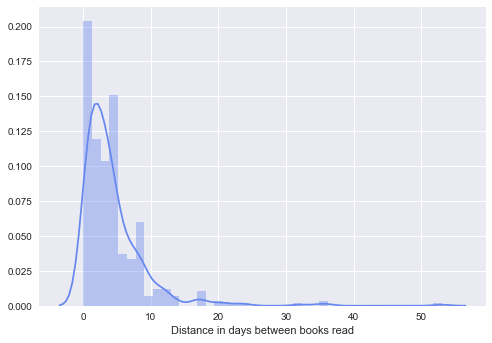

In [9]:
# first, transform to datetype and get rid of all invalid dates
dates = pd.to_datetime(cleaned_df["Date Read"])
dates = dates.dropna()
sorted_dates = sorted(dates)

last_date = None
differences = []
all_days = []
all_days_without_2012 = [] # not much goodreads usage in 2012 - remove that year
for date in sorted_dates:
    if not last_date:
        last_date = date
        if date.year != 2012:
            last_date_not_2012 = date
    difference = date - last_date
    
    days = difference.days
    all_days.append(days)
    if date.year != 2012:
        all_days_without_2012.append(days)
    last_date = date

sns.distplot(all_days_without_2012, axlabel="Distance in days between books read")
pylab.show()

***

## plot Heatmap of dates read

Parses the "dates read" for each book read, bins them by month, and makes a heatmap to show in which months I read more than in others. Also makes a lineplot for books read, split up by year.

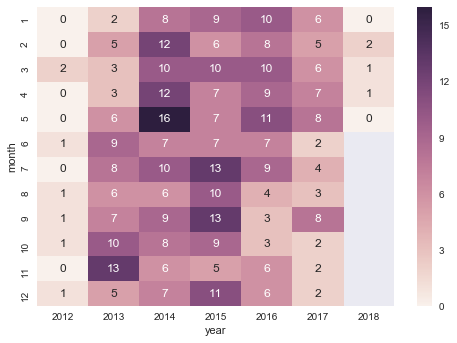

In [10]:
# we need a dataframe in this format:
# year months books_read
# I am sure there's some magic pandas function for this

read_dict = defaultdict(int) # key: (year, month), value: count of books read
for date in sorted_dates:
    this_year = date.year
    this_month = date.month
    read_dict[ (this_year, this_month) ] += 1

first_date = sorted_dates[0]

first_year = first_date.year
first_month = first_date.month

todays_date = datetime.datetime.today()
todays_year = todays_date.year
todays_month = todays_date.month

all_years = []
all_months = []
all_counts = []
for year in range(first_year, todays_year+1):
    for month in range(1, 13):
        if (year == todays_year) and month > todays_month:
            # don't count future months
            # it's 2015-12 now so a bit hard to test
            break
        this_count = read_dict[ (year, month) ]
        all_years.append(year)
        all_months.append(month)
        all_counts.append(this_count)

# now get it in the format heatmap() wants
df = pd.DataFrame( { "month":all_months, "year":all_years, "books_read":all_counts } )
dfp = df.pivot("month", "year", "books_read")

# now make the heatmap
ax = sns.heatmap(dfp, annot=True)

What happened in May 2014?

Update in 2018 - currently the 'date_read' column doesn't accurately track which books were actually read, this is a bug on Goodreads' end

***

## Plot books read by year

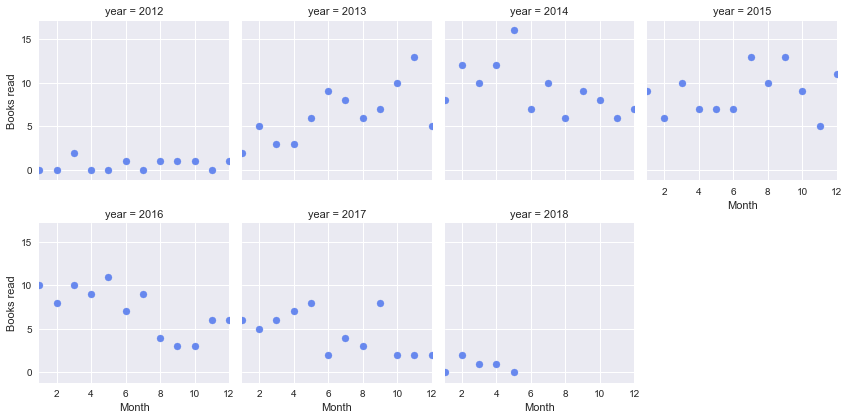

In [11]:
g = sns.FacetGrid(df, col="year", sharey=True, sharex=True, col_wrap=4)
g.map(plt.scatter, "month", "books_read")
g.set_ylabels("Books read")
g.set_xlabels("Month")
pylab.xlim(1, 12)
pylab.show()

It's nice how reading behaviour (Goodreads usage) connects over the months - it slowly in 2013, stays constant in 2014/2015, and now goes down again. You can see when my son was born!

(Solution: 2016-8-25)

***

## Guessing authors' genders

Let's check whether I read mostly male or female authors using the gender-guesser package!

In [12]:
first_names = cleaned_df['Author'].str.split(' ',expand=True)[0]
d = gender.Detector(case_sensitive=False)

genders = [d.get_gender(name) for name in first_names]
print(zip(genders[:5], first_names[:5]))
# let's also add those few 'mostly_female' and 'mostly_male' into the main grou
genders = pd.Series([x.replace('mostly_female','female').replace('mostly_male','male') for x in genders])

[(u'male', 'Thomas'), (u'male', 'Paul'), (u'unknown', 'Plato'), (u'male', 'Michel'), (u'female', 'Joan')]


male       504
unknown     95
female      56
andy        11
dtype: int64


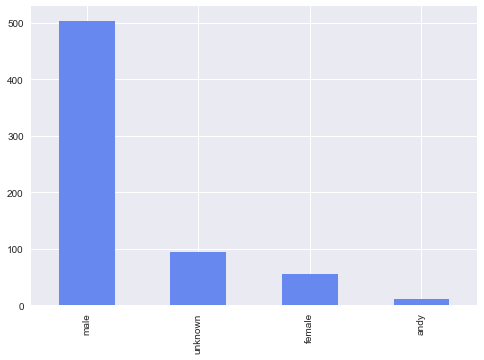

In [13]:
gender_ratios = genders.value_counts()
print(gender_ratios)
_ = gender_ratios.plot(kind='bar')

Now THAT'S gender bias. Do I rate the genders differently?

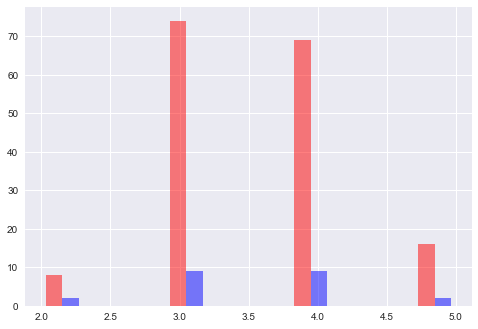

In [14]:
cleaned_df['Gender'] = genders

male_scores = cleaned_df[cleaned_df['Gender'] == 'male']['My Rating'].values
female_scores = cleaned_df[cleaned_df['Gender'] == 'female']['My Rating'].values

_ = plt.hist([male_scores, female_scores], color=['r','b'], alpha=0.5)

Hard to tell any difference since there are so fewer women authors here - let's split them up into different plots

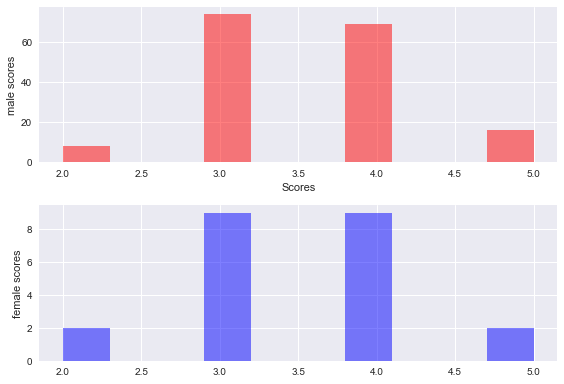

In [15]:
fig, axes = plt.subplots(2,1)

axes[0].hist(male_scores, color='r', alpha=0.5, bins=10)
axes[0].set_xlabel('Scores')
# Make the y-axis label, ticks and tick labels match the line color.
axes[0].set_ylabel('male scores')

axes[1].hist(female_scores, color='b', alpha=0.5, bins=10)
axes[1].set_ylabel('female scores')

fig.tight_layout()

Are these two samples from the same distribution? Hard to tell since their size is so different, but let's ask Kolmogorov-Smirnov (null hypothesis: they are from the same distribution)

In [16]:
scipy.stats.ks_2samp(male_scores, female_scores)

Ks_2sampResult(statistic=0.04300489929232444, pvalue=0.9999999999998631)

We cannot reject the null hypthesis as the p-value is very, very high. (but again, there are so few female scores...)


***

## Compare with Goodreads 10k


A helpful soul has uploaded ratings and stats for the 10,000 books with most ratings on Goodreads (https://github.com/zygmuntz/goodbooks-10k). Let's compare those with my ratings!

In [17]:
other = pd.read_csv('./goodbooks-10k/books.csv')
print(other.columns)
other.head(3)

Index([u'book_id', u'goodreads_book_id', u'best_book_id', u'work_id',
       u'books_count', u'isbn', u'isbn13', u'authors',
       u'original_publication_year', u'original_title', u'title',
       u'language_code', u'average_rating', u'ratings_count',
       u'work_ratings_count', u'work_text_reviews_count', u'ratings_1',
       u'ratings_2', u'ratings_3', u'ratings_4', u'ratings_5', u'image_url',
       u'small_image_url'],
      dtype='object')


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


What's the gender ratio here?

male             4643
female           3400
unknown          1220
mostly_male       350
mostly_female     338
andy               49
dtype: int64


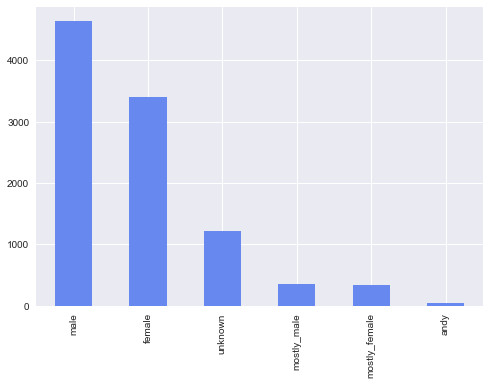

In [18]:

other_first_names = other.authors.str.split(' ',expand=True)[0]
for index, x in enumerate(other_first_names):
    if x == 'J.R.R.':
        other_first_names[index] = 'John'
    elif x == 'J.K.':
        other_first_names[index] = 'Joanne'
    elif x == 'F.':
        other_first_names[index] = 'Francis'
    elif x == 'C.S.':
        other_first_names[index] = 'Clive'
    elif x == 'J.D.':
        other_first_names[index] = 'Jerome'
        
other_genders = pd.Series([d.get_gender(name) for name in other_first_names])
gender_ratios = other_genders.value_counts()
print(gender_ratios)
_ = gender_ratios.plot(kind='bar')

other['Gender'] = other_genders

A bit better than my own reviews!

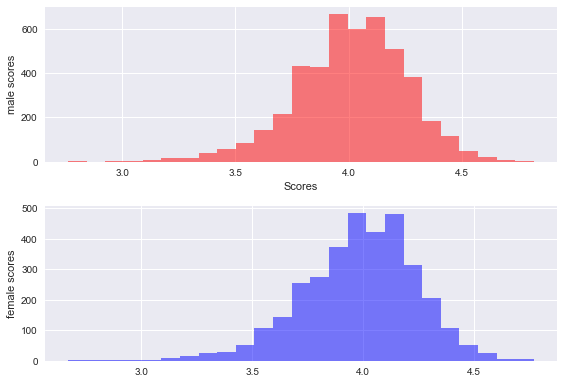

In [19]:
male_scores = other[other['Gender'] == 'male']['average_rating'].values
female_scores = other[other['Gender'] == 'female']['average_rating'].values

fig, axes = plt.subplots(2,1)

axes[0].hist(male_scores, color='r', alpha=0.5, bins=25)
axes[0].set_xlabel('Scores')
# Make the y-axis label, ticks and tick labels match the line color.
axes[0].set_ylabel('male scores')

axes[1].hist(female_scores, color='b', alpha=0.5, bins=25)
axes[1].set_ylabel('female scores')

fig.tight_layout()

Very similar, again, with a slight shift to the right in the 'female scores'

Is my 'Book Id' the same as the other's table 'goodreads_book_id'?

In [20]:
both = other.merge(cleaned_df, how='inner', left_on='goodreads_book_id', right_on='Book Id')
print('My reviews: %s, 10k Reviews: %s, Intersection: %s'%(cleaned_df.shape, other.shape, both.shape))

My reviews: (666, 32), 10k Reviews: (10000, 24), Intersection: (253, 56)


Looks good! Now check which is the most common and the most obscure book in my list

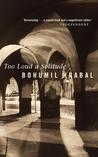

In [21]:
Image(both.sort_values(by='ratings_count').head(1).image_url.iloc[0])

Too Loud A Solitude, a wonderful book, you should read it!

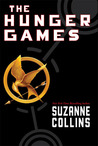

In [22]:
Image(both.sort_values(by='ratings_count').tail(1).image_url.iloc[0])

For which book does my rating have the highest difference in score?

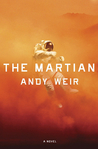

Book: The Martian, My rating: 2 Global average rating: 4.4


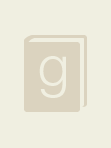

Book: The Dice Man, My rating: 1 Global average rating: 3.59


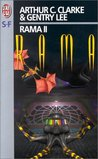

Book: Rama II (Rama, #2), My rating: 1 Global average rating: 3.67


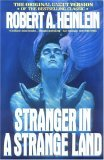

Book: Stranger in a Strange Land, My rating: 1 Global average rating: 3.91


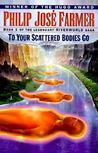

Book: To Your Scattered Bodies Go (Riverworld, #1), My rating: 1 Global average rating: 3.94


In [23]:
my_rating = cleaned_df['My Rating']
other_ratings = cleaned_df['Average Rating']
cleaned_df['Difference Rating'] = np.abs(my_rating - other_ratings)
ten_biggest_diff = cleaned_df.sort_values(by='Difference Rating').tail(10)

for x in ten_biggest_diff.iterrows():
    book_id = x[1]['Book Id']
    ten_thousand_books_info = other.where(other['goodreads_book_id'] == book_id).dropna()
    try:
        this_image_url = ten_thousand_books_info.image_url.iloc[0]
    except IndexError:
        # not found in big table
        continue
    display(Image(this_image_url))
    details = x[1]
    print('Book: %s, My rating: %s Global average rating: %s'%(details['Title'], details['My Rating'], details['Average Rating'] ))

Do I have many differences in how I rate my book when compared with the community?

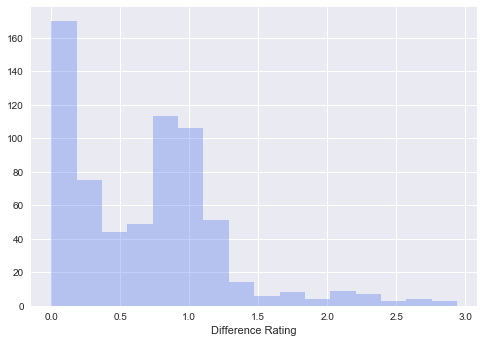

In [24]:
sns.distplot(cleaned_df['Difference Rating'], kde=False)

Not really, mostly 0 and 1 difference.

## plot Word Cloud


This one removes noisy words and creates a word-cloud of most commonly used words in the reviews.

You have 68649 words in 436 reviews


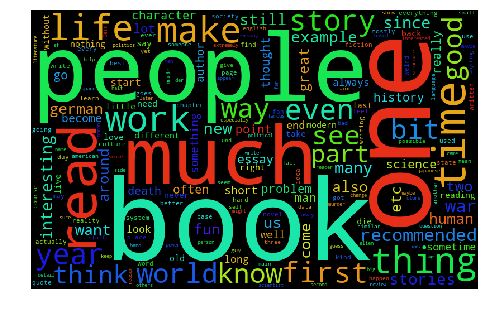

In [25]:
def replace_by_space(word):
    new = []
    for letter in word:
        if letter in REMOVE:
            new.append(' ')
        else:
            new.append(letter)
    return ''.join(new)

STOP = stopwords.words("english")
html_clean = re.compile('<.*?>')
gr_clean = re.compile('\[.*?\]')
PRINTABLE = string.printable
REMOVE = set(["!","(",")",":",".",";",",",'"',"?","-",">","_"])

all_my_words = []
all_my_words_with_stop_words = []

reviews = cleaned_df["My Review"]

num_reviews = 0
num_words = 0
for row in reviews:
    if pd.isnull(row):
        continue
    review = row.lower()
    if not review:
        # empty review
        continue
    # clean strings
    cleaned_review = re.sub(html_clean, '', review)
    cleaned_review = re.sub(gr_clean, '', cleaned_review)
    all_my_words_with_stop_words += cleaned_review
    cleaned_review = replace_by_space(cleaned_review)
    cleaned_review = "".join(filter(lambda x: x in PRINTABLE, cleaned_review))
    # clean words
    cleaned_review = cleaned_review.split()
    cleaned_review = list(filter(lambda x: x not in STOP, cleaned_review))
    num_words += len(cleaned_review)
    all_my_words += cleaned_review
    num_reviews += 1

print("You have %s words in %s reviews"%(num_words, num_reviews))

# we need all words later for the Markov chain
all_my_words_with_stop_words = ''.join(all_my_words_with_stop_words)

# WordCloud takes only string, no list/set
wordcloud = WordCloud(max_font_size=200, width=800, height=500).generate(' '.join(all_my_words))
pylab.imshow(wordcloud)
pylab.axis("off")
pylab.show()

***

## plot books read vs. week-day

Let's parse the weekday a "book read" has been added and count them

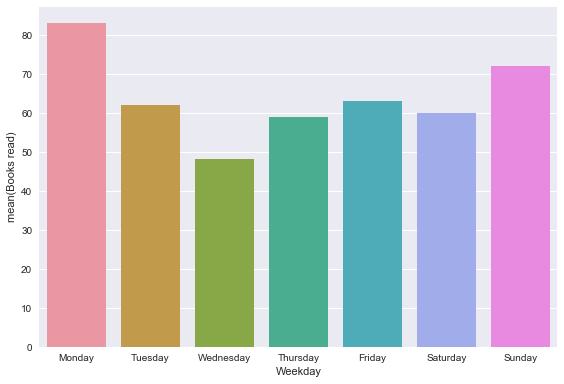

In [26]:
# initialize the dict in the correct order
read_dict = OrderedDict() # key: weekday, value: count of books read
for day in range(0,7):
    read_dict[calendar.day_name[day]] = 0

for date in sorted_dates:
    weekday_name = calendar.day_name[date.weekday()]  # Sunday
    read_dict[weekday_name] += 1

full_table = pd.DataFrame({"Weekday":list(read_dict.keys()), "Books read":list(read_dict.values())})

sns.barplot(x="Weekday", y="Books read", data=full_table)
plt.tight_layout()
plt.show()


Monday is procrastination day.

***

## Generate Reviews

Tiny script that uses a simple Markov Chain and the review text as created by plotWordCloud.py to generate new reviews.
Some examples:

* “natural” death, almost by definition, means something slow, smelly and painful
* a kind of cyborg, saved by the master was plagued in his work - for that i'm getting angry again just typing this - some are of exactly the opposite, and of black holes
* american actress wikipedia tells me) once said: "a critic never fights the battle; they just read, focus on his own goshawk 50 years
* he always wanted to do something, and i don't know how accurate he is
* not recommended for: people who, if they can't be reduced to a small essay
* machiavelli summarises quite a bit like reading a 120 pages summary of the helmet of horror
* - no supervisor, no grant attached to a beautiful suicide and now i cleared my mind of circe's orders -cramping my style, urging me not to write the paper
* not being focused on useless mobile apps, but on medical companies that treat death as a sign of dissent
* the harassment of irs-personnel to get into the dark cave
* they're doing "good"
* i think it's supposed to be the worst essay is a vampire: "interview with a strong voice and judges the poem by the use of might (hitler is referenced several times) - the 4 alternating voices quickly blur into one network of states
* one or two minor problems: you need to murder his children

*why does this work so well*

This script also creates a graph of probabilities for word connections for the word "translation", the thicker the edge between the nodes, the higher the probability.

a serious case of impostor's syndrome


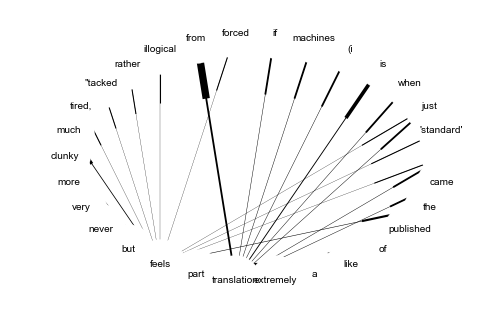

In [27]:
mc = MarkovChain(dbFilePath='./markov_db')
mc.generateDatabase(all_my_words_with_stop_words)

print(mc.generateString())

mc.dumpdb()

# a key in the datbase looks like:
# ('when', 'you') defaultdict(<function _one at 0x7f5c843a4500>, 
# {'just': 0.06250000000059731, 'feel': 0.06250000000059731, 'had': 0.06250000000059731, 'accidentally': 0.06250000000059731, ''love': 0.06250000000059731, 'read': 0.06250000000059731, 'see': 0.06250000000059731, 'base': 0.06250000000059731, 'know': 0.12499999999641617, 'have': 0.12499999999641617, 'were': 0.06250000000059731, 'come': 0.06250000000059731, 'can't': 0.06250000000059731, 'are': 0.06250000000059731})
# so 'just' follows after 'when you' with 6% probability

db = pickle.load(open('./markov_db', 'rb'))
# let's get a good node
#for key in db:
#    # has in between 5 and 10 connections
#    if len(db[key]) > 5 and (len(db[key]) < 10):
#        if len(set(db[key].values())) > 2:
#            print key, set(db[key].values())

# manually chosen from above
good_key = ('translation',)
values = db[good_key]

# create the graph

G = nx.DiGraph()
good_key = str(good_key[0])
G.add_node(good_key)
G.add_nodes_from(values.keys())
# get the graph for one of the connected nodes
# we go only one step deep - anything more and we'd better use recursion (but graph gets ugly then anyway)
for v in values:
    if (v,) in db and (len(db[(v,)]) < 20):
        G.add_nodes_from(db[(v,)].keys())
        for partner in db[(v,)]:
            edge_weight = db[(v,)][partner]
            G.add_weighted_edges_from([ (v, partner, edge_weight) ])
        # for now, only add one
        break

# now add the edges of the "original" graph around "translation"
for partner in values:
    edge_weight = values[partner]
    G.add_weighted_edges_from([ (good_key, partner, edge_weight) ])

pos = nx.shell_layout(G)

nx.draw_networkx_nodes(G, pos, node_color = 'white', node_size = 2500)

# width of edges is based on probability * 10
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist = [(edge[0], edge[1])], width = edge[2]['weight']*10)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
pylab.axis('off')
pylab.show()

***

## Some other ideas

- Some people on goodreads have complained that their reviews disappear and I feel (but don't know) that I lost at least one, this tracks my exported CSV to check whether it actually happens. So far I haven't observed it.
- ~~Write automated parser that exports reviews to html/epub/tumblr/blogger/wordpress etc.~~ support for this was added to goodreads)
- ~~cron job which automatically pulls exported CSV from https://www.goodreads.com/review_porter/goodreads_export.csv (login a bit weird esp. with Facebook login, use API instead? Needs dev key, but easier to do /review/list.xml=USERID than to play Red Queen with Facebook's oauth)~~ see github.com/philippbayer/Goodreads_to_Tumblr
- various visualization things in regards to language use
- RNN to write automated reviews, similar to the Markov one. also have to look at embeddings to predict category of book?